In [1]:
import numpy as np 
import pandas as pd 
import os
from joblib import Parallel, delayed
import SimpleITK as sitk
from scipy import ndimage
from math import floor,ceil
import matplotlib.pyplot as plt

In [2]:
def volume(center, size):
    
    data = {}
    
    oz, oy, ox = center
    h, w, l = size

    x = np.linspace(ox-l/2,ox+l/2,num=10)
    y = np.linspace(oy-w/2,oy+w/2,num=10)
    z = np.linspace(oz-h/2,oz+h/2,num=10)
    
    data['x1'], data['z1'] = np.meshgrid(x, z)
    data['y11'] = np.ones_like(data['x1'])*(oy-w/2)
    data['y12'] = np.ones_like(data['x1'])*(oy+w/2)
    data['x2'], data['y2'] = np.meshgrid(x, y)
    data['z21'] = np.ones_like(data['x2'])*(oz-h/2)
    data['z22'] = np.ones_like(data['x2'])*(oz+h/2)
    data['y3'], data['z3'] = np.meshgrid(y, z)
    data['x31'] = np.ones_like(data['y3'])*(ox-l/2)
    data['x32'] = np.ones_like(data['y3'])*(ox+l/2)
    
    return data

In [3]:
def plot_cuboid(VOLUMES, axeslimits):

    from mpl_toolkits.mplot3d import Axes3D
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection='3d')
    ax.set_aspect('equal', adjustable='box')
    for k, val in VOLUMES.items():
        color='g'
        if k=='patient':
            color='b'
        if k=='nodule':
            color='r'
        data = VOLUMES[k]
        ax.plot_wireframe(val['x1'], val['y11'], val['z1'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x1'], val['y12'], val['z1'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x2'], val['y2'], val['z21'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x2'], val['y2'], val['z22'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x31'], val['y3'], val['z3'], color=color, rstride=10, cstride=10, alpha=0.6)
        ax.plot_wireframe(val['x32'], val['y3'], val['z3'], color=color, rstride=10, cstride=10, alpha=0.6)
    
    ax.set_xlim(np.max(axeslimits), 0)
    ax.set_xlabel('X')
    ax.set_ylim(0, np.max(axeslimits))
    ax.set_ylabel('Y')
    ax.set_zlim(0, np.max(axeslimits))
    ax.set_zlabel('Z')
    plt.show()

In [4]:
def voxels_nodule(DIRECTORY,PATIENT,DF,VIEWS=6,VOXEL_SIZE=64):
    itkimage = sitk.ReadImage('../data/'+DIRECTORY+PATIENT+'.mhd')
    img = sitk.GetArrayFromImage(itkimage)
    origin = np.array(list(reversed(itkimage.GetOrigin()))) # zyx
    spacing = np.array(list(reversed(itkimage.GetSpacing()))) # zyx

    # use only df rows pertaining to this patient
    DF['ix'] = range(DF.shape[0])
    dfsub = DF[DF['seriesuid']==PATIENT]
    if dfsub.shape[0] == 0:
        print ('error') # return None

    # initialize list to hold voxels and corresponding indices
    trues = []
    falses = []
    trues_ix = []
    falses_ix = []
    count = 0
    dataset = {}

    # image coordinates if centered at zero
    img_max = img.shape*spacing
    dataset['patient'] = volume(list(img_max/2), list(img_max))

    # voxel shape with original image spacing
    voxel_shape = np.round(np.array([VOXEL_SIZE,VOXEL_SIZE,VOXEL_SIZE])/spacing)
    min_jitter = [ceil(m) for m in (voxel_shape/2)]
    max_jitter = [floor(m) for m in (img.shape-voxel_shape/2)]

    while count < VIEWS*dfsub.shape[0]:
        print ('\tView..',count+1)
        random_ZYX = np.array([np.random.randint(mi,ma) for mi,ma in zip(min_jitter,max_jitter)])
        print ('\t\tRandom center',random_ZYX)
        voxel_max = (random_ZYX + np.round(voxel_shape/2)).astype(int)
        voxel_min = (random_ZYX - (voxel_shape-np.round(voxel_shape/2))).astype(int)
        print ('\t\tRandom max and min',voxel_max,voxel_min)
        print ('\t\tRandom shape',voxel_max-voxel_min)

        voxel = img[voxel_min[0]:voxel_max[0],voxel_min[1]:voxel_max[1],voxel_min[2]:voxel_max[2]]
        print ('\t\tVoxel shape',voxel.shape)

        # now let's see if this voxel contains at least one nodule
        nodules = 0
        for nodule in range(dfsub.shape[0]):
            row = dfsub.iloc[nodule]
            nodule_ZYX = np.array([row['coordZ'],row['coordY'],row['coordX']])
            nodule_ZYX = np.round(np.absolute(nodule_ZYX-origin)/ spacing)

            if (nodule_ZYX<voxel_max).all() and (nodule_ZYX>voxel_min).all():
                nodules += 1

        if nodules==0:

            count += 1
            maxdiam_ix = -1

            print ('\t\tNo nodule',count)
            dataset[count+1] = volume(list((voxel_min+voxel_shape/2)*spacing), list(voxel_shape*spacing))
            falses_ix.append(maxdiam_ix)

            # resize voxel spacing to 1mmx1mmx1mm
            voxel_norm = ndimage.interpolation.zoom(voxel,spacing,order=1)
            print ('\t\tVoxel norm',voxel_norm.shape)
            voxel_norm = np.clip(voxel_norm, -1000, 400)
            print ('\t\tResized voxel shape',voxel_norm.shape)
            voxel_norm = np.transpose(voxel_norm, (2,1,0)) #X,Y,Z 
            falses.append(voxel_norm)
        else:
            print ('\t\t!Nodule found!')
            continue

    plot_cuboid(dataset, list(img_max))

    dataset = {}
    dataset['patient'] = volume(list(img_max/2), list(img_max))

    # for each nodule
    for nodule in range(dfsub.shape[0]):

        # set the row so that it's only referencing the nodule of choice
        row = dfsub.iloc[nodule]

        # grab diameter of nodule, divide by spacing to adjust to patient spacing
        nodule_rad = row['diameter_mm']/spacing/2

        # nodule coordinates based on original image origin
        nodule_ZYX = np.array([row['coordZ'],row['coordY'],row['coordX']])
        print ('Original nodule coords',nodule_ZYX)
        print ('\tOrigin',origin)

        # shift nodule coordinates to origin of 0 instead of image origin
        nodule_ZYX = np.absolute(nodule_ZYX-origin)
        print ('\tAdjusted to origin [0,0,0]',nodule_ZYX)

        # adjust coordinates such that reflective of patient array spacing
        nodule_ZYX = np.round(nodule_ZYX / spacing)
        print ('\tAdjusted for spacing and rounded',nodule_ZYX)

        # nodule volume limits
        nodule_max = np.array([ceil(c) for c in nodule_ZYX+nodule_rad])
        nodule_min = np.array([floor(c) for c in nodule_ZYX-nodule_rad])
        nodule_shape = nodule_max-nodule_min
        print ('Nodule shape',nodule_shape)

        dataset['nodule'] = volume(list(nodule_ZYX*spacing), list(nodule_shape*spacing))

        # set max value of movement around nodule
        max_jitter = np.amin(np.stack((abs(nodule_max-img.shape),voxel_shape-nodule_shape)),axis=0)
        print ('Max Jitter',max_jitter)

        # set min value of movement around nodule
        min_jitter = nodule_min-max_jitter
        min_jitter[min_jitter > 0.] = 0.
        min_jitter = np.abs(min_jitter)
        print ('Min Jitter',min_jitter)

        print ('Number of views..',VIEWS)
        #for the number of views, grab voxel around nodule
        for i in range(VIEWS):
            print ('\tView..',i+1)
            jitter = np.array([np.random.randint(mi,ma) for mi,ma in zip(min_jitter,max_jitter)])
            voxel_max = nodule_max + jitter
            voxel_min = (nodule_min - (voxel_shape-nodule_shape-jitter)).astype(int)
            print ('\t\tVoxel coords',voxel_max,voxel_min)
            print ('\t\tVoxel max-min',voxel_max-voxel_min)

            voxel = img[voxel_min[0]:voxel_max[0],voxel_min[1]:voxel_max[1],voxel_min[2]:voxel_max[2]]
            print ('\t\tVoxel shape',voxel.shape)

            # now let's see if this voxel contains more than one nodule
            maxdiam_ix = -1
            maxdiam = 0
            for nodule in range(dfsub.shape[0]):
                row = dfsub.iloc[nodule]
                nodule_ZYX = np.array([row['coordZ'],row['coordY'],row['coordX']])
                nodule_ZYX = np.round(np.absolute(nodule_ZYX-origin)/ spacing)

                if (nodule_ZYX<voxel_max).all() and (nodule_ZYX>voxel_min).all():
                    if row['diameter_mm'] > maxdiam:
                        maxdiam_ix = row['ix']
                        maxdiam = row['diameter_mm']

            dataset[i] = volume(list((voxel_min+voxel_shape/2)*spacing), list(voxel_shape*spacing))
            trues_ix.append(maxdiam_ix)

            # resize voxel spacing to 1mmx1mmx1mm
            voxel_norm = ndimage.interpolation.zoom(voxel,spacing,order=1)
            print ('\t\tVoxel norm',voxel_norm.shape)
            voxel_norm = np.clip(voxel_norm, -1000, 400)
            print ('\t\tResized voxel shape',voxel_norm.shape)
            voxel_norm = np.transpose(voxel_norm, (2,1,0)) #X,Y,Z 
            trues.append(voxel_norm)

        plot_cuboid(dataset, list(img_max))

    trues_array = np.stack(trues)
    trues_ix_array = np.array(trues_ix).astype('int32')
    falses_array = np.stack(falses)
    falses_ix_array = np.array(falses_ix).astype('int32')

    return trues_array,trues_ix_array,falses_array,falses_ix_array

In [5]:
df = pd.read_csv('../data/CSVFILES/annotations_enhanced.csv')
patient = '1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524522225658609808059'
directory = 'subset0/'

	View.. 1
		Random center [ 68 345 262]
		Random max and min [ 94 403 320] [ 43 286 203]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		No nodule 1
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 2
		Random center [107 242 222]
		Random max and min [133 300 280] [ 82 183 163]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		No nodule 2
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 3
		Random center [122 323 207]
		Random max and min [148 381 265] [ 97 264 148]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		No nodule 3
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 4
		Random center [ 47 136 441]
		Random max and min [ 73 194 499] [ 22  77 382]
		Random shape [ 51 117 117]
		Voxel shape (51, 117, 117)
		No nodule 4
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 5
		Random center [ 74 407 429]
		Random max and min [100 465 487] [ 49 348 370]
		Random shape [ 51 117

/home/gantos/.local/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


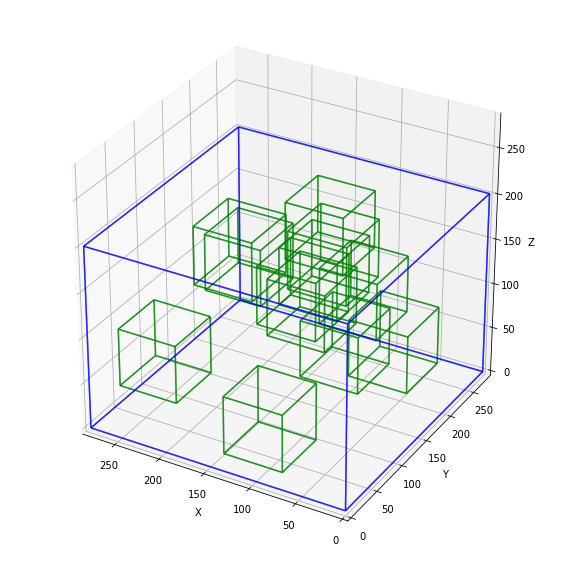

Original nodule coords [-108.5786324    48.40280596   46.18853869]
	Origin [-194.       -108.300003 -187.699997]
	Adjusted to origin [0,0,0] [  85.4213676   156.70280896  233.88853569]
	Adjusted for spacing and rounded [  68.  286.  426.]
Nodule shape [12 26 26]
Max Jitter [ 39.  91.  73.]
Min Jitter [ 0.  0.  0.]
Number of views.. 6
	View.. 1
		Voxel coords [ 74 372 441] [ 23 255 324]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 2
		Voxel coords [110 373 452] [ 59 256 335]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 3
		Voxel coords [105 373 506] [ 54 256 389]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 4
		Voxel coords [ 83 350 506] [ 32 233 389]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resiz

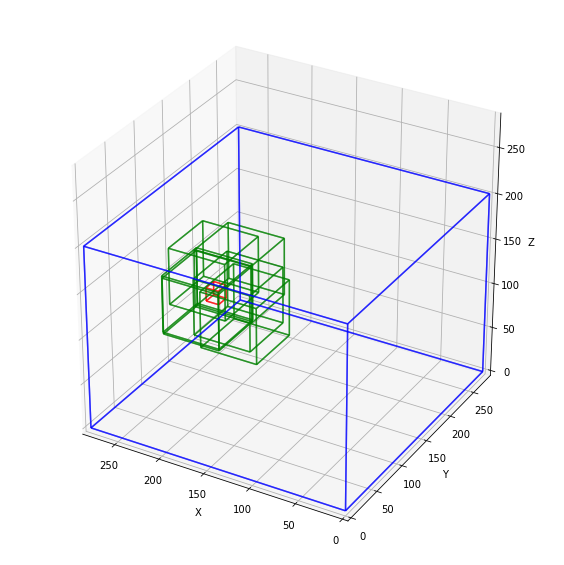

Original nodule coords [-123.3219112    76.77166265   36.39204443]
	Origin [-194.       -108.300003 -187.699997]
	Adjusted to origin [0,0,0] [  70.6780888   185.07166565  224.09204143]
	Adjusted for spacing and rounded [  57.  337.  408.]
Nodule shape [4 8 8]
Max Jitter [  47.  109.  100.]
Min Jitter [ 0.  0.  0.]
Number of views.. 6
	View.. 1
		Voxel coords [ 96 439 417] [ 45 322 300]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 2
		Voxel coords [ 77 440 434] [ 26 323 317]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 3
		Voxel coords [ 94 407 502] [ 43 290 385]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resized voxel shape (64, 64, 64)
	View.. 4
		Voxel coords [ 90 386 500] [ 39 269 383]
		Voxel max-min [ 51 117 117]
		Voxel shape (51, 117, 117)
		Voxel norm (64, 64, 64)
		Resiz

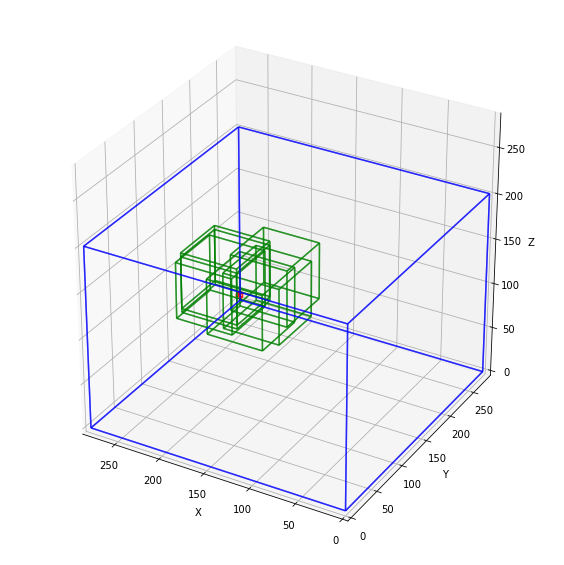

In [6]:
results = voxels_nodule(directory,patient,df)